# This notebook contains the experimental trials for the test hyperparameters. 

In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

/home/zach/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-12-12 14:07:06.283582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 14:07:06.913180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 14:07:06.913533: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on

/tmp/ipykernel_14382/1816619194.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


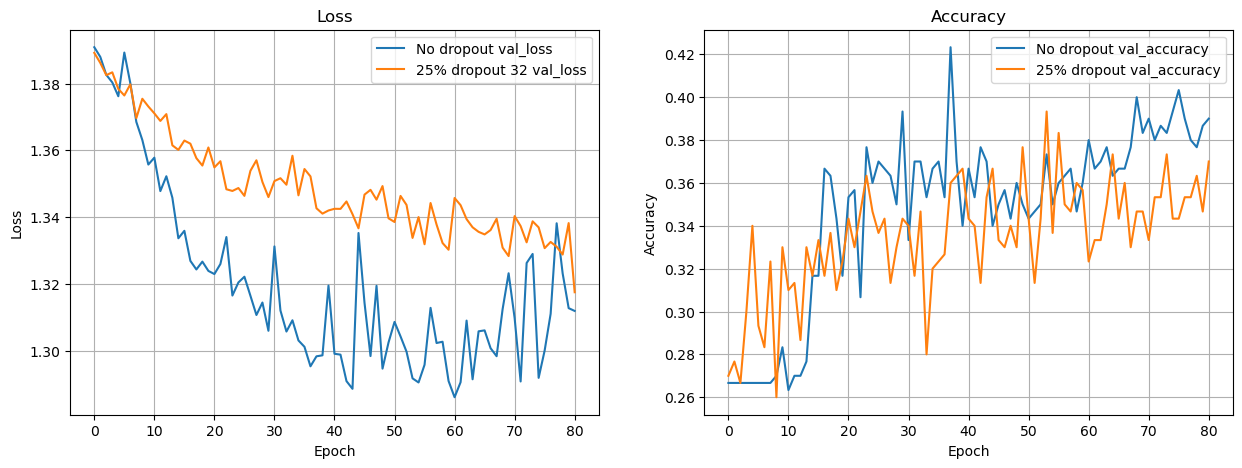

In [27]:
h = pd.read_csv('model_d0_hist.csv')
h2 = pd.read_csv('model_d25_hist.csv')

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(h['val_loss'].head(81), label = "No dropout val_loss")
plt.plot(h2['val_loss'].head(81), label = "25% dropout 32 val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(h['val_accuracy'].head(81), label = "No dropout val_accuracy")
plt.plot(h2['val_accuracy'].head(81), label = "25% dropout val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Import data from CSVs

In [2]:
# Read in data from CSV files

TOTAL_IMAGES = 1500
IMG_SIZE = (256, 256)

train = pd.read_csv('datasets/train_set.csv',
                    usecols=['Image Index', 'Finding Label']
                   ).sample(int(TOTAL_IMAGES * 0.6), random_state=42)

test = pd.read_csv('datasets/test_set.csv', 
                    usecols=['Image Index', 'Finding Label']
                   ).sample(int(TOTAL_IMAGES * 0.2), random_state=42)

val = pd.read_csv('datasets/val_set.csv', 
                    usecols=['Image Index', 'Finding Label']
                   ).sample(int(TOTAL_IMAGES * 0.2), random_state=42)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Validation shape: {val.shape}")

Train shape: (900, 2)
Test shape: (300, 2)
Validation shape: (300, 2)


In [3]:
# Ensure that all classes are represented within the sets
print(len(train['Finding Label'].unique()) == len(test['Finding Label'].unique()))
print(len(train['Finding Label'].unique()) == len(val['Finding Label'].unique()))

True
True


In [4]:
# Read in image data and separate into images and labels

x_train = []
y_train = []

for index in train.index:
    fpath = train.loc[index, 'Image Index']
    x_train.append(cv2.resize(cv2.imread(f'images/{fpath}'), IMG_SIZE))
    y_train.append(train.loc[index, 'Finding Label'])
    
x_test = []
y_test = []

for index in test.index: 
    fpath = test.loc[index, 'Image Index']
    x_test.append(cv2.resize(cv2.imread(f'images/{fpath}'), IMG_SIZE))
    y_test.append(test.loc[index, 'Finding Label'])
    
x_val = []
y_val = []

for index in val.index: 
    fpath = val.loc[index, 'Image Index']
    x_val.append(cv2.resize(cv2.imread(f'images/{fpath}'), IMG_SIZE))
    y_val.append(val.loc[index, 'Finding Label'])

In [5]:
# Cast images to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

In [6]:
# Apply min-max normalization to image arrays
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

In [7]:
# Apply one-hot encoding to image labels
y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)
y_val_encoded = pd.get_dummies(y_val)

In [8]:
# Tell model to stop training when validation loss stops improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 15)

# monitor = tf.keras.callbacks.ModelCheckpoint('1500_1e-5_34.h5', 
#                                              monitor='val_loss',
#                                              verbose=0,
#                                              save_best_only=True,
#                                              save_weights_only=True,
#                                              mode='min',
#                                             )
# # Learning rate schedule
# def scheduler(epoch, lr):
#     if epoch%10 == 0:
#         lr = lr/2
#     return lr

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [9]:
LR = 1e-4
k = y_train_encoded.shape[1]

def model(my_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), k=k, lr=LR):
    model_input = tf.keras.layers.Input(shape=my_shape)
    l1 = tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(model_input)
    l2 = tf.keras.layers.MaxPool2D((2,2))(l1)
    l3_drop = tf.keras.layers.Dropout(0.25)(l2)
    l4 = tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu')(l3_drop)
    l5 = tf.keras.layers.MaxPool2D((2,2))(l4)
    flat = tf.keras.layers.Flatten()(l5)
    l6 = tf.keras.layers.Dense(64, activation='relu')(flat)
    l7 = tf.keras.layers.Dropout(0.25)(l6)
    l8 = tf.keras.layers.Dense(32, activation='relu')(l7)
    out = tf.keras.layers.Dense(k, activation='softmax')(l8)
    model = tf.keras.models.Model(inputs=model_input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [10]:
my_model = model()

batch_size = 64
epochs = 40

history = my_model.fit(x_train,
                      y_train_encoded,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val, y_val_encoded),
                      callbacks=[early_stop]
                     )

2022-12-11 18:36:40.292455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-11 18:36:40.292481: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-11 18:36:40.292519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zach-VivoBook-ASUSLaptop-X530FA-S530FA): /proc/driver/nvidia/version does not exist
2022-12-11 18:36:40.293222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 18:36:41.201376: W tensorflow/tsl/

Epoch 1/40


2022-12-11 18:36:43.734841: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.
2022-12-11 18:36:46.507489: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.


 1/15 [=>............................] - ETA: 1:17 - loss: 1.3966 - accuracy: 0.1875

2022-12-11 18:36:47.881803: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.
2022-12-11 18:36:50.577837: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.


15/15 [==============================] - 60s 4s/step - loss: 1.5435 - accuracy: 0.2644 - val_loss: 1.3883 - val_accuracy: 0.2967
Epoch 2/40
15/15 [==============================] - 57s 4s/step - loss: 1.4233 - accuracy: 0.2778 - val_loss: 1.3874 - val_accuracy: 0.2133
Epoch 3/40
15/15 [==============================] - 56s 4s/step - loss: 1.3999 - accuracy: 0.2611 - val_loss: 1.3828 - val_accuracy: 0.2667
Epoch 4/40
15/15 [==============================] - 54s 4s/step - loss: 1.3916 - accuracy: 0.2578 - val_loss: 1.3841 - val_accuracy: 0.2967
Epoch 5/40
15/15 [==============================] - 54s 4s/step - loss: 1.3785 - accuracy: 0.2500 - val_loss: 1.3837 - val_accuracy: 0.2700
Epoch 6/40
15/15 [==============================] - 54s 4s/step - loss: 1.3790 - accuracy: 0.2689 - val_loss: 1.3856 - val_accuracy: 0.2933
Epoch 7/40
15/15 [==============================] - 54s 4s/step - loss: 1.3764 - accuracy: 0.2889 - val_loss: 1.3849 - val_accuracy: 0.2867
Epoch 8/40
15/15 [=============

Test loss (cross-entropy and accuracy): [1.3681035041809082, 0.2800000011920929]



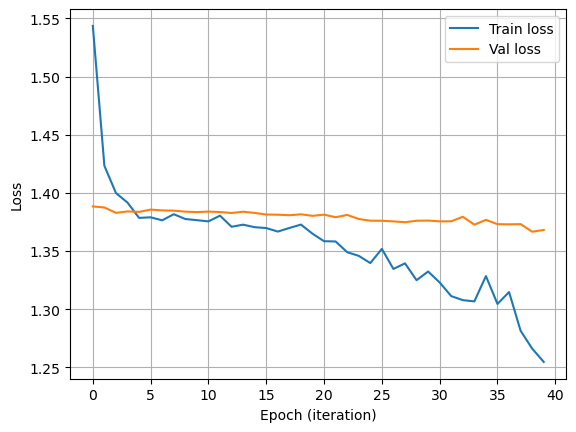

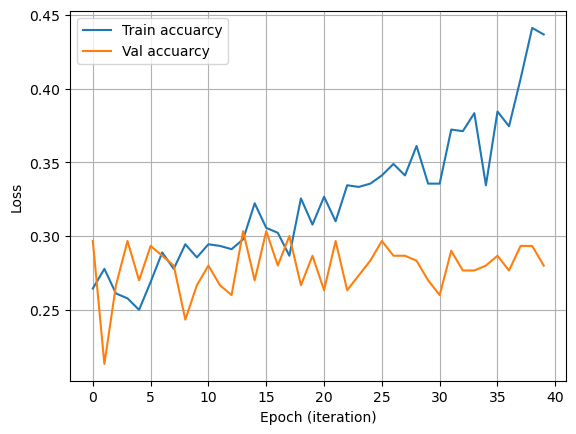

In [11]:
loss = my_model.evaluate(x_val, y_val_encoded, verbose=0)
print('Test loss (cross-entropy and accuracy):',loss)
print()

plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history['accuracy'], label = "Train accuracy")
plt.plot(history.history['val_accuracy'], label = "Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [12]:
my_model.save('1500_1e-4.h5')
pd.DataFrame(history.history).to_csv("1500_1e-4_hist.csv")

In [9]:
LR = 1e-5
k = y_train_encoded.shape[1]

def model1(my_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), k=k, lr=LR):
    model_input = tf.keras.layers.Input(shape=my_shape)
    l1 = tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(model_input)
    l2 = tf.keras.layers.MaxPool2D((2,2))(l1)
    l3_drop = tf.keras.layers.Dropout(0.25)(l2)
    l4 = tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu')(l3_drop)
    l5 = tf.keras.layers.MaxPool2D((2,2))(l4)
    flat = tf.keras.layers.Flatten()(l5)
    l6 = tf.keras.layers.Dense(64, activation='relu')(flat)
    l7 = tf.keras.layers.Dropout(0.25)(l6)
    l8 = tf.keras.layers.Dense(32, activation='relu')(l7)
    out = tf.keras.layers.Dense(k, activation='softmax')(l8)
    model = tf.keras.models.Model(inputs=model_input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [10]:
my_model1 = model1()

batch_size = 64
epochs = 40

history1 = my_model1.fit(x_train,
                      y_train_encoded,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val, y_val_encoded),
                      callbacks=[early_stop]
                     )

2022-12-11 19:20:48.725221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-11 19:20:48.725257: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-11 19:20:48.725292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zach-VivoBook-ASUSLaptop-X530FA-S530FA): /proc/driver/nvidia/version does not exist
2022-12-11 19:20:48.725628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 19:20:49.566084: W tensorflow/tsl/

Epoch 1/40


2022-12-11 19:20:50.966166: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.
2022-12-11 19:20:51.364933: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.
2022-12-11 19:20:51.649926: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.
2022-12-11 19:20:53.541445: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.


15/15 [==============================] - 59s 4s/step - loss: 1.3937 - accuracy: 0.2389 - val_loss: 1.3884 - val_accuracy: 0.2667
Epoch 2/40
15/15 [==============================] - 59s 4s/step - loss: 1.3941 - accuracy: 0.3022 - val_loss: 1.3835 - val_accuracy: 0.2667
Epoch 3/40
15/15 [==============================] - 57s 4s/step - loss: 1.3770 - accuracy: 0.2811 - val_loss: 1.3824 - val_accuracy: 0.2700
Epoch 4/40
15/15 [==============================] - 59s 4s/step - loss: 1.3659 - accuracy: 0.2989 - val_loss: 1.3812 - val_accuracy: 0.2667
Epoch 5/40
15/15 [==============================] - 58s 4s/step - loss: 1.3733 - accuracy: 0.3056 - val_loss: 1.3764 - val_accuracy: 0.2667
Epoch 6/40
15/15 [==============================] - 59s 4s/step - loss: 1.3657 - accuracy: 0.2944 - val_loss: 1.3737 - val_accuracy: 0.2800
Epoch 7/40
15/15 [==============================] - 58s 4s/step - loss: 1.3755 - accuracy: 0.2733 - val_loss: 1.3761 - val_accuracy: 0.2800
Epoch 8/40
15/15 [=============

Test loss (cross-entropy and accuracy): [1.3463778495788574, 0.36000001430511475]



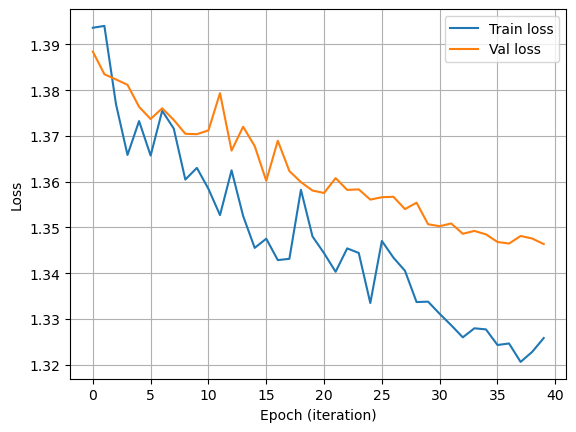

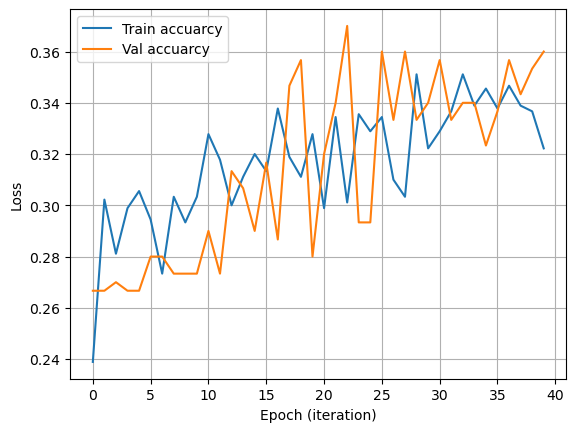

In [12]:
loss = my_model1.evaluate(x_val, y_val_encoded, verbose=0)
print('Test loss (cross-entropy and accuracy):',loss)
print()

plt.plot(history1.history['loss'], label = "Train loss")
plt.plot(history1.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history1.history['accuracy'], label = "Train accuracy")
plt.plot(history1.history['val_accuracy'], label = "Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [14]:
my_model1.save('1500_1e-5.h5')
pd.DataFrame(history1.history).to_csv("1500_1e-5_hist.csv")

In [10]:
my_model2 = model1()

batch_size = 32
epochs = 40

history2 = my_model2.fit(x_train,
                      y_train_encoded,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val, y_val_encoded),
                      callbacks=[early_stop, monitor]
                     )

2022-12-11 20:48:03.860005: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-11 20:48:03.860040: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-11 20:48:03.860074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zach-VivoBook-ASUSLaptop-X530FA-S530FA): /proc/driver/nvidia/version does not exist
2022-12-11 20:48:03.860751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 20:48:03.955123: W tensorflow/tsl/

Epoch 1/40


2022-12-11 20:48:05.590030: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 62980096 exceeds 10% of free system memory.


29/29 [==============================] - 53s 2s/step - loss: 1.3815 - accuracy: 0.3089 - val_loss: 1.3798 - val_accuracy: 0.2667
Epoch 2/40
29/29 [==============================] - 55s 2s/step - loss: 1.3802 - accuracy: 0.2989 - val_loss: 1.3810 - val_accuracy: 0.3033
Epoch 3/40
29/29 [==============================] - 54s 2s/step - loss: 1.3592 - accuracy: 0.3156 - val_loss: 1.3746 - val_accuracy: 0.2800
Epoch 4/40
29/29 [==============================] - 54s 2s/step - loss: 1.3634 - accuracy: 0.3067 - val_loss: 1.3707 - val_accuracy: 0.2900
Epoch 5/40
29/29 [==============================] - 54s 2s/step - loss: 1.3590 - accuracy: 0.3367 - val_loss: 1.3731 - val_accuracy: 0.3133
Epoch 6/40
29/29 [==============================] - 54s 2s/step - loss: 1.3591 - accuracy: 0.3189 - val_loss: 1.3711 - val_accuracy: 0.3467
Epoch 7/40
29/29 [==============================] - 54s 2s/step - loss: 1.3492 - accuracy: 0.3222 - val_loss: 1.3685 - val_accuracy: 0.3267
Epoch 8/40
29/29 [=============

Test loss (cross-entropy and accuracy): [1.3359086513519287, 0.36000001430511475]



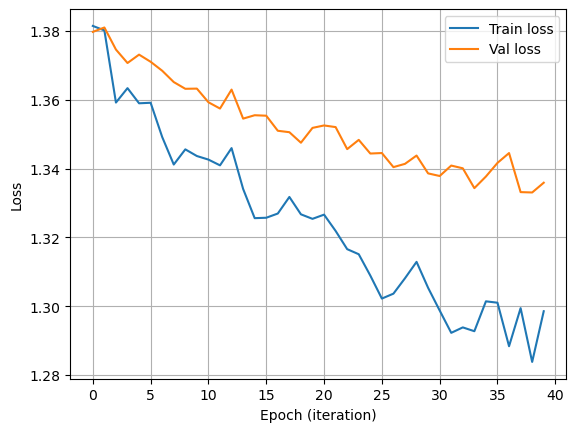

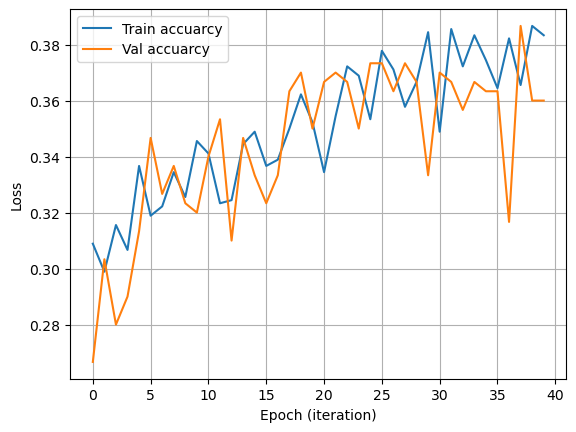

In [11]:
loss = my_model2.evaluate(x_val, y_val_encoded, verbose=0)
print('Test loss (cross-entropy and accuracy):',loss)
print()

plt.plot(history2.history['loss'], label = "Train loss")
plt.plot(history2.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history2.history['accuracy'], label = "Train accuracy")
plt.plot(history2.history['val_accuracy'], label = "Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [13]:
my_model2.save('1500_1e-5_32.h5')
pd.DataFrame(history2.history).to_csv("1500_1e-5_32_hist.csv")

In [9]:
LR = 1e-5
k = y_train_encoded.shape[1]

def model3(my_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), k=k, lr=LR):
    model_input = tf.keras.layers.Input(shape=my_shape)
    l1 = tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(model_input)
    l2 = tf.keras.layers.MaxPool2D((2,2))(l1)
    l4 = tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu')(l2)
    l5 = tf.keras.layers.MaxPool2D((2,2))(l4)
    flat = tf.keras.layers.Flatten()(l5)
    l6 = tf.keras.layers.Dense(64, activation='relu')(flat)
    l8 = tf.keras.layers.Dense(32, activation='relu')(l6)
    out = tf.keras.layers.Dense(k, activation='softmax')(l8)
    model = tf.keras.models.Model(inputs=model_input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [10]:
my_model3 = model3()

batch_size = 64
epochs = 40

history3 = my_model3.fit(x_train,
                      y_train_encoded,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val, y_val_encoded),
                      callbacks=[early_stop]
                     )

2022-12-12 02:42:37.060240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-12 02:42:37.060283: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 02:42:37.060299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zach-VivoBook-ASUSLaptop-X530FA-S530FA): /proc/driver/nvidia/version does not exist
2022-12-12 02:42:37.060902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 02:42:37.185795: W tensorflow/tsl/

Epoch 1/40


2022-12-12 02:42:38.869805: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 62980096 exceeds 10% of free system memory.


15/15 [==============================] - 51s 3s/step - loss: 1.3792 - accuracy: 0.2800 - val_loss: 1.3988 - val_accuracy: 0.2667
Epoch 2/40
15/15 [==============================] - 49s 3s/step - loss: 1.3694 - accuracy: 0.3189 - val_loss: 1.3858 - val_accuracy: 0.2833
Epoch 3/40
15/15 [==============================] - 48s 3s/step - loss: 1.3732 - accuracy: 0.3122 - val_loss: 1.3781 - val_accuracy: 0.3067
Epoch 4/40
15/15 [==============================] - 48s 3s/step - loss: 1.3691 - accuracy: 0.3056 - val_loss: 1.3888 - val_accuracy: 0.2967
Epoch 5/40
15/15 [==============================] - 48s 3s/step - loss: 1.3642 - accuracy: 0.3144 - val_loss: 1.3888 - val_accuracy: 0.2667
Epoch 6/40
15/15 [==============================] - 48s 3s/step - loss: 1.3697 - accuracy: 0.2733 - val_loss: 1.3850 - val_accuracy: 0.3167
Epoch 7/40
15/15 [==============================] - 48s 3s/step - loss: 1.3611 - accuracy: 0.3244 - val_loss: 1.3736 - val_accuracy: 0.2800
Epoch 8/40
15/15 [=============

Test loss (cross-entropy and accuracy): [1.2871159315109253, 0.3766666650772095]



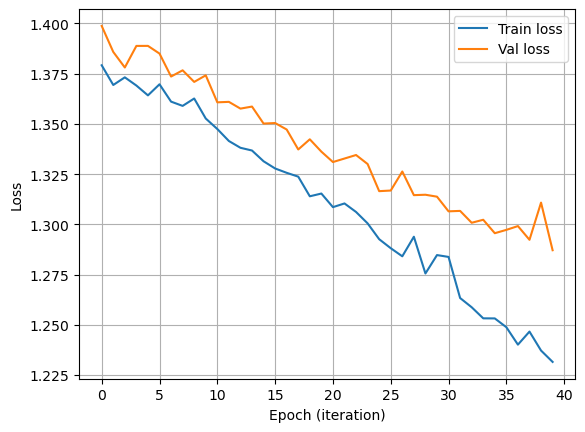

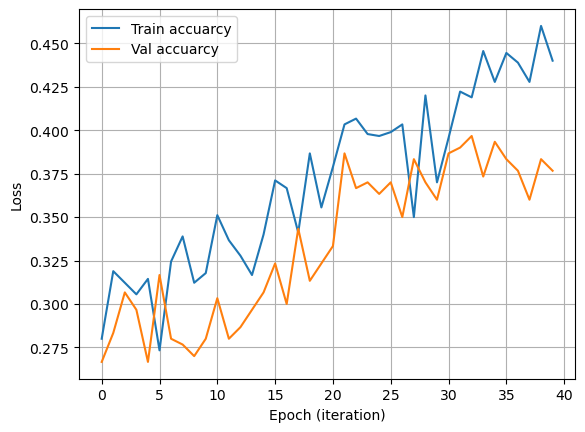

In [11]:
loss = my_model3.evaluate(x_val, y_val_encoded, verbose=0)
print('Test loss (cross-entropy and accuracy):',loss)
print()

plt.plot(history3.history['loss'], label = "Train loss")
plt.plot(history3.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history3.history['accuracy'], label = "Train accuarcy")
plt.plot(history3.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()

In [13]:
my_model3.save('1500_1e-5_64_d0.h5')
pd.DataFrame(history3.history).to_csv("1500_1e-5_64_d0_hist.csv")

In [14]:
m = tf.keras.models.load_model('1500_1e-5_64_d8.h5')
print(m.evaluate(x_val, y_val_encoded, verbose=0))

[1.3359086513519287, 0.36000001430511475]


Test loss (cross-entropy and accuracy): [1.3643966913223267, 0.3166666626930237]



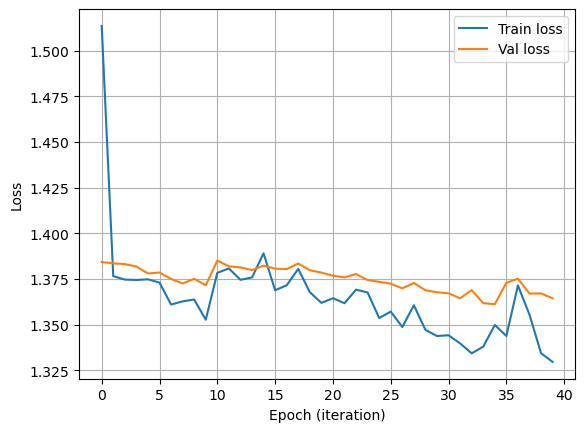

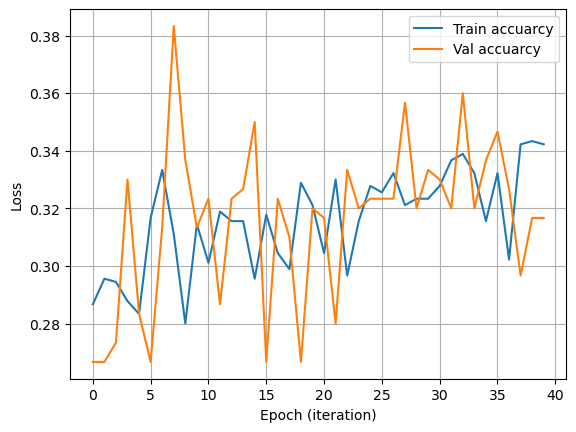

In [11]:
loss = my_model.evaluate(x_val, y_val_encoded, verbose=0)
print('Test loss (cross-entropy and accuracy):',loss)
print()
# W = my_model.get_weights()
# for ii in range(len(W)//2):
#     print("Layer %d" %ii)
#     print('Bias:\n', W[2*ii + 1])
#     print('W:\n', W[2*ii])
#     print()

plt.plot(history2.history['loss'], label = "Train loss")
plt.plot(history2.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history2.history['accuracy'], label = "Train accuarcy")
plt.plot(history2.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()